In [63]:
import networkx as nx 
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import operator
import time
import random
# DELTA_RECOVER = 7
# DELTA_INFECT = 5
# p_transmit_virus = .015
# SEED = .04
infected = set()

In [64]:
#build scale free networks
def build_networks(days, N):
    networks = list()
    for i in range(days):
        G = nx.read_gexf(f"./Graphs/{i+1}.gexf")
        networks.append(G)
    return networks

In [65]:
#This makes all 'conservative' and 'liberal' users 'infected' at the beginning.

def init_population(mode,N, m, networks):
    G = networks[0]
    for person in G.nodes:
        if G.nodes[person]['political_label'] == 'Conservative' or G.nodes[person]['political_label'] == 'Liberal':
            infected.add(person)
    
    for person in G.nodes:
        if G.nodes[person]['political_label'] == 'Conservative' or G.nodes[person]['political_label'] == 'Liberal':
            G.nodes[person]['status'] = 'infected'
            G.nodes[person]['day_infected'] = 1
        else:
            G.nodes[person]['status'] = ''   
            G.nodes[person]['day_infected'] = -1  
    
    return infected

In [66]:
#Susceptible-Infected-recovered simulation 
def run_experiment(days,networks,infected, mitigation_mode, label):
    for day in range(days):
        new_infected = set()
        G = networks[day]
        for person in infected:
            if person in G.nodes:
                neighbors = list(G.neighbors(person)) 
                for neighbor in neighbors:
                    if random.random() <= G.nodes[person][f'{label}_politicalness'] and day != (days-1):
                        new_infected.add(neighbor)
                        try:
                            networks[day+1].nodes[neighbor]['status'] = 'infected'
                            networks[day+1].nodes[neighbor]['day_infected'] = day
                        except KeyError:
                            pass
        infected.update(new_infected)
    return 



In [67]:
def plot_SIR(networks,days):
    plt.figure()
    plt.plot([x for x in range(days-1)], [len([y[0] for y in networks[x].nodes.data() if y[1]['status'] == 'infected']) for x in range(days-1)], label='infected')
    plt.legend()
    plt.grid()
    plt.title("Number of Infections vs Day")
    plt.xlabel("Day")
    plt.ylabel("Number of infections")
    plt.show()    
    return 

In [68]:
def average_pol(G, n, label):
    pols = []
    for _, _, data in G.out_edges(n, data=True):
        pols.append(data[f'avg_{label}_pol'])
    return np.average(pols) if pols else 0

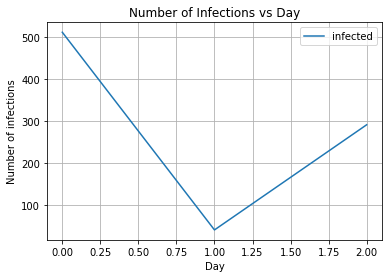

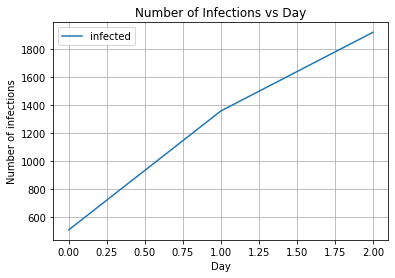

In [69]:
def main():
    
    #init experiment based on 
    days = 4
    N = 1
    m = 1 
    networks = build_networks(days,N)
    for network in networks:
        for person in network:
            network.nodes[person]['status'] = ''
            network.nodes[person]['day_infected'] = -1
            network.nodes[person]['conservative_politicalness'] = average_pol(networks[0], person,'Conservative')*1000
            network.nodes[person]['liberal_politicalness'] = average_pol(networks[0], person,'Liberal')*1000
    
    #initialize population for top 5 degrees 
    infected = init_population("top_degree", N, m, networks)


    

    # print(networks[0].nodes['Bigron808'])
    # print(networks[0].nodes['Adelaidey'])
    # print(networks[0].nodes['zalecot'])
    #run SIR experiment A
    run_experiment(days,networks, infected, 0, 'conservative')
    plot_SIR(networks,days)

    networks = build_networks(days,N)
    for network in networks:
        for person in network:
            network.nodes[person]['status'] = ''
            network.nodes[person]['day_infected'] = -1
            network.nodes[person]['conservative_politicalness'] = average_pol(networks[0], person,'Conservative')*1000
            network.nodes[person]['liberal_politicalness'] = average_pol(networks[0], person,'Liberal')*1000

    infected = init_population("top_degree", N, m, networks)
    run_experiment(days,networks, infected, 0, 'liberal')
    plot_SIR(networks,days)
if __name__ == '__main__':
    main()
